# ANL488 Final Report JAN23


    Ernest Pek Jun Wei (B1981095) 
  

Submission date: May 8th 2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import random
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.dates as mdates
import pmdarima as pm

## Importing the Monthly Household Electricity Consumption data

In [2]:
# Load and Preprocess the data
df = pd.read_csv('electricity_demand_data.csv')
df.columns = ['Date', 'Consumption']
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')
df.set_index('Date', inplace=True)
display(df)

,Consumption
Date,
2005-01-01,418.1
2005-02-01,408.3
2005-03-01,446.9
2005-04-01,496.2
2005-05-01,496.8
...,...
2021-08-01,509.5
2021-09-01,468.5
2021-10-01,455.4


### Electrical Consumption data visualised

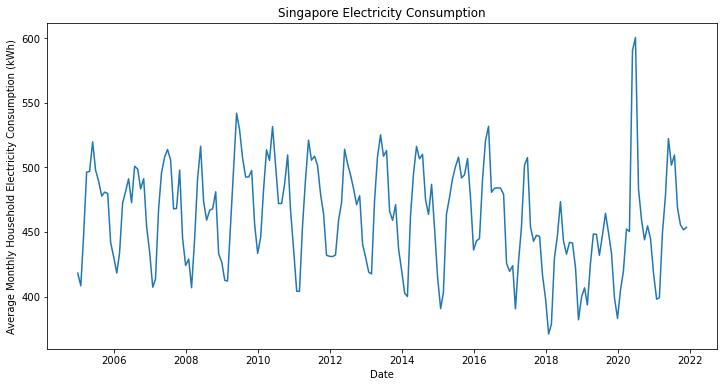

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Consumption'])
plt.xlabel('Date')
plt.ylabel('Average Monthly Household Electricity Consumption (kWh)')
plt.title('Singapore Electricity Consumption')
plt.show()

### Detecting and Replacing Outliers

In [4]:
# Detect outliers using IQR method
def detect_outliers_iqr(data, multiplier=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[((data < (Q1 - multiplier * IQR)) | (data > (Q3 + multiplier * IQR)))]

outliers = detect_outliers_iqr(df['Consumption'])
print(f"Outliers:\n{outliers}")

# Replace outliers with linear interpolation
df_interpolated = df.copy()
df_interpolated.loc[outliers.index, 'Consumption'] = np.nan
df_interpolated['Consumption'] = df_interpolated['Consumption'].interpolate(method='time')

Outliers:
Date
2020-06-01    590.4
2020-07-01    600.5
Name: Consumption, dtype: float64


### Visualising the Electrical Consumption data after replacing outliers

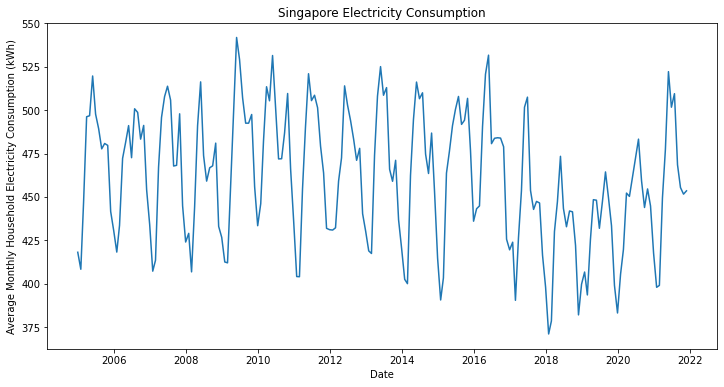

In [5]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df_interpolated['Consumption'])
plt.xlabel('Date')
plt.ylabel('Average Monthly Household Electricity Consumption (kWh)')
plt.title('Singapore Electricity Consumption')
plt.show()

In [6]:
# Check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(df_interpolated['Consumption'])

ADF Statistic: -1.888166
p-value: 0.337649


ADF Statistic: -4.527142
p-value: 0.000176


C:\Users\65927\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


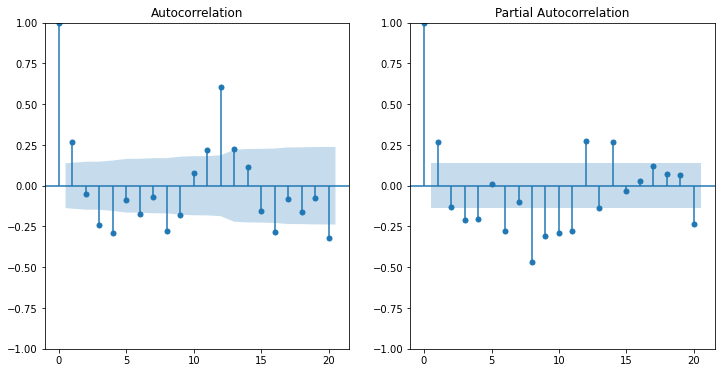

In [7]:
# Difference the data
df_diff = df_interpolated['Consumption'].diff().dropna()
adf_test(df_diff)

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df_diff, lags=20, ax=ax1)
plot_pacf(df_diff, lags=20, ax=ax2)
plt.show()

## Importing the Population Growth data

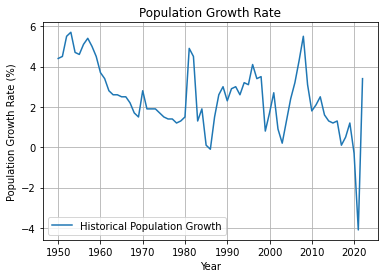

,Total Population Growth (Per Cent)
Year,
1950-01-01,4.4
1951-01-01,4.5
1952-01-01,5.5
1953-01-01,5.7
1954-01-01,4.7
...,...
2018-01-01,0.5
2019-01-01,1.2
2020-01-01,-0.3


In [8]:
# Load and preprocess the population growth data
pop_growth_df = pd.read_csv('Population Growth.csv')
pop_growth_df.columns = ['Year', 'Total Population Growth (Per Cent)']
pop_growth_df['Year'] = pd.to_datetime(pop_growth_df['Year'], format='%Y')
pop_growth_df.set_index('Year', inplace=True)

# Plot historical population growth data
plt.plot(pop_growth_df.index, pop_growth_df['Total Population Growth (Per Cent)'], label='Historical Population Growth')

# Format the plot
plt.xlabel('Year')
plt.ylabel('Population Growth Rate (%)')
plt.title('Population Growth Rate')
plt.legend()
plt.grid()

# Show the plot
plt.show()
#display the dataframe
display(pop_growth_df)

### Detecting and replacing the outliers

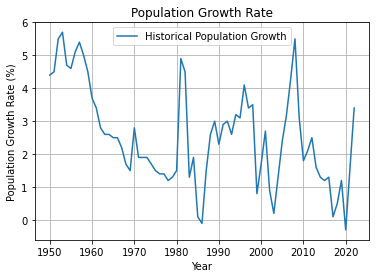

In [9]:
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_out = df[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]
    return df_out

# Remove the outliers using the IQR method
pop_growth_no_outliers = remove_outliers_iqr(pop_growth_df, 'Total Population Growth (Per Cent)')

# Reindex the DataFrame to ensure a continuous date range
date_range = pd.date_range(start=pop_growth_df.index.min(), end=pop_growth_df.index.max(), freq='YS')
pop_growth_no_outliers = pop_growth_no_outliers.reindex(date_range)

# Interpolate missing data points using linear interpolation
pop_growth_interpolated = pop_growth_no_outliers.interpolate(method='linear')


# Plot historical population growth data
plt.plot(pop_growth_interpolated.index, pop_growth_interpolated['Total Population Growth (Per Cent)'], label='Historical Population Growth')

# Format the plot
plt.xlabel('Year')
plt.ylabel('Population Growth Rate (%)')
plt.title('Population Growth Rate')
plt.legend()
plt.grid()

# Show the plot
plt.show()

## Importing the Power Plant Capacity data
### Calculating the Total Capacity and the Capacity Factors
### Converting the data from MW to MWh

In [10]:
# Load the dataset
plant_availability_factors = pd.read_csv('Plant Availability Factors.csv')

# Calculate the Total Capacity for each month
plant_availability_factors['Total Capacity'] = plant_availability_factors['Remaining Capacity (MW)'] + plant_availability_factors['Outage Capacity (MW)']

# Calculate the capacity factor for each month
plant_availability_factors['Capacity Factor'] = plant_availability_factors['Remaining Capacity (MW)'] / plant_availability_factors['Total Capacity']

# Calculate the number of hours in a month
hours_per_month = 30 * 24

# Convert capacities to MWh
plant_availability_factors['Remaining Capacity (MWh)'] = plant_availability_factors['Remaining Capacity (MW)'] * hours_per_month
plant_availability_factors['Outage Capacity (MWh)'] = plant_availability_factors['Outage Capacity (MW)'] * hours_per_month
plant_availability_factors['Total Capacity (MWh)'] = plant_availability_factors['Total Capacity'] * hours_per_month

# Display the dataset with capacity factors
display(plant_availability_factors)

,Month,Outage Capacity (MW),Remaining Capacity (MW),Total Capacity,Capacity Factor,Remaining Capacity (MWh),Outage Capacity (MWh),Total Capacity (MWh)
0,1/1/2003,954,8085.0,9039.0,0.894457,5821200.0,686880,6508080.0
1,1/2/2003,1818,7221.0,9039.0,0.798872,5199120.0,1308960,6508080.0
2,1/3/2003,2004,7035.0,9039.0,0.778294,5065200.0,1442880,6508080.0
3,1/4/2003,1364,7676.0,9040.0,0.849115,5526720.0,982080,6508800.0
4,1/5/2003,1377,7663.0,9040.0,0.847677,5517360.0,991440,6508800.0
...,...,...,...,...,...,...,...,...
235,1/8/2022,2831,9842.4,12673.4,0.776619,7086528.0,2038320,9124848.0
236,1/9/2022,2513,10174.1,12687.1,0.801925,7325352.0,1809360,9134712.0
237,1/10/2022,2229,10457.4,12686.4,0.824300,7529328.0,1604880,9134208.0
238,1/11/2022,2704,9996.3,12700.3,0.787092,7197336.0,1946880,9144216.0


### Visualising the Total Capacity data

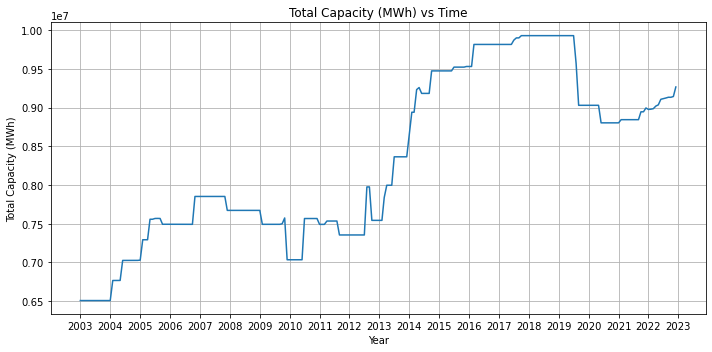

In [11]:
plant_availability_factors['Month'] = pd.to_datetime(plant_availability_factors['Month'], format='%d/%m/%Y')
plant_availability_factors.set_index('Month', inplace=True)

# Plot total capacity (MWh) vs time
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plant_availability_factors.index, plant_availability_factors['Total Capacity (MWh)'])

# Set x-axis labels to display only years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Total Capacity (MWh)')
plt.title('Total Capacity (MWh) vs Time')
plt.grid()
plt.tight_layout()
plt.show()

## Importing the Household to Total Consumption data

In [12]:
#proportion of household to total electricity consumption
#Retrieved from: https://www.ema.gov.sg/singapore-energy-statistics/Ch03/index3
data = {
    'Year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'Proportion': [0.157, 0.151, 0.150, 0.150, 0.149, 0.152, 0.156, 0.147, 0.143, 0.148]
}
proportions_df = pd.DataFrame(data)

# Calculate the median and interquartile range
q1 = proportions_df['Proportion'].quantile(0.25)
q3 = proportions_df['Proportion'].quantile(0.75)
iqr = q3 - q1

# Replace outliers with the median
median = proportions_df['Proportion'].median()
proportions_df['Proportion'] = np.where(
    ((proportions_df['Proportion'] < (q1 - 1.5 * iqr)) | (proportions_df['Proportion'] > (q3 + 1.5 * iqr))), median,proportions_df['Proportion'])

### Visualising the Household:Total Consumption data

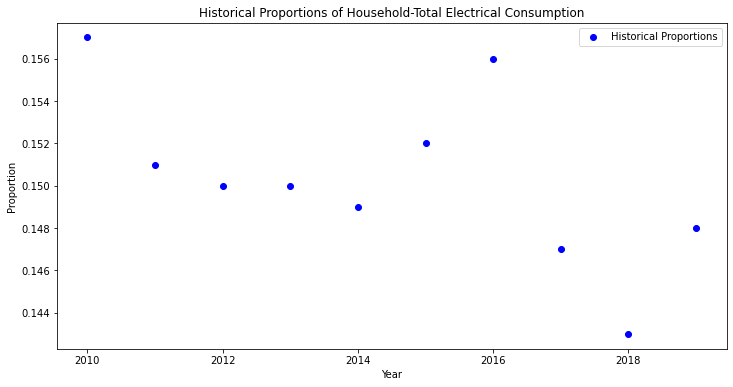

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(proportions_df['Year'], proportions_df['Proportion'], label='Historical Proportions', color='blue')

plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Historical Proportions of Household-Total Electrical Consumption')
plt.legend(loc='upper right')
plt.show()

# Modelling
## SARIMA for the Household Electrical Consumption

In [14]:
# Find the best SARIMA model
best_model = pm.auto_arima(df_interpolated,
                           seasonal=True, m=12,
                           d=1, D=1,
                           max_p=3, max_q=3,
                           max_P=3, max_Q=3,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1715.490, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1673.248, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1716.014, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1661.378, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1657.716, Time=0.49 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1656.138, Time=0.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1660.110, Time=0.18 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=1653.700, Time=0.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1656.2

Mean Absolute Percentage Error (MAPE): 6.15
Mean Squared Error: 1046.19
Root Mean Squared Error: 32.34


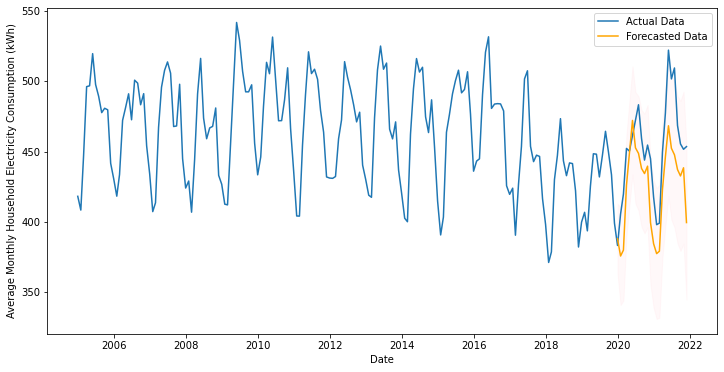

In [15]:
# Train-test split
train_data = df_interpolated[:-24]  # Leave the last 24 months for testing
test_data = df_interpolated[-24:]

# Fit the best SARIMA model on the training data
best_model.fit(train_data)

# Forecast the next 24 months (replace 24 with any number of months you want to forecast)
forecast, conf_int = best_model.predict(n_periods=24, return_conf_int=True)

# Evaluate the model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data.iloc[:, 0] - forecast) / test_data.iloc[:, 0])) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f}".format(mape))
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


# Create a date index for the forecast
forecast_index = pd.date_range(test_data.index[0], periods=24, freq='MS')

# Convert the forecast and confidence intervals to pandas series
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Plot the actual data, forecast, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df_interpolated, label='Actual Data')
plt.plot(forecast_series, label='Forecasted Data', color='orange')
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Average Monthly Household Electricity Consumption (kWh)')
plt.legend()
plt.show()

### Forecasting the Consumption for 10 years

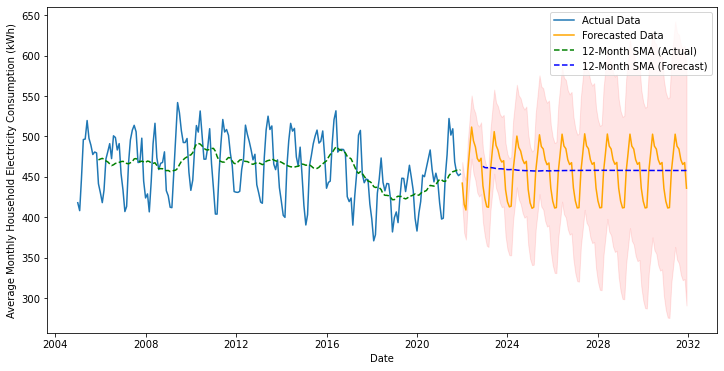

In [16]:
# Train the model on the entire dataset
best_model.fit(df_interpolated)

# Forecast the next 120 months (10 years)
forecast, conf_int = best_model.predict(n_periods=120, return_conf_int=True)

# Create a date index for the forecast
forecast_index = pd.date_range(df.index[-1], periods=121, closed='right', freq='MS')

# Convert the forecast and confidence intervals to pandas series
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Calculate the 12-month simple moving average for the actual and forecasted data
sma_window = 12
sma_series_actual = df_interpolated.rolling(window=sma_window).mean()
sma_series_forecast = forecast_series.rolling(window=sma_window).mean()

# Plot the actual data, forecast, confidence intervals, and SMA for both actual and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df_interpolated, label='Actual Data')
plt.plot(forecast_series, label='Forecasted Data', color='orange')
plt.fill_between(forecast_index, lower_series, upper_series, color='red', alpha=0.1)
plt.plot(sma_series_actual, label=f'{sma_window}-Month SMA (Actual)', color='green', linestyle='--')
plt.plot(sma_series_forecast, label=f'{sma_window}-Month SMA (Forecast)', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Monthly Household Electricity Consumption (kWh)')
plt.legend()
plt.show()

## SARIMA for Population Growth

In [17]:
# Find the best SARIMA model for population growth data
pop_best_model = pm.auto_arima(pop_growth_interpolated,
                               seasonal=True, m=12,
                               d=1, D=1,
                               max_p=3, max_q=3,
                               max_P=3, max_Q=3,
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

# Train the best SARIMA model on the entire population growth dataset
pop_best_model.fit(pop_growth_interpolated)

# Forecast the next 10 years for population growth
pop_forecast = pop_best_model.predict(n_periods=10)

# Create a date index for the population growth forecast
pop_forecast_index = pd.date_range(pop_growth_interpolated.index[-1], periods=10, closed='right', freq='YS')

# Convert the population growth forecast to a pandas series
pop_forecast_series = pd.Series(pop_forecast, index=pop_forecast_index)

# Create the forecasted_population_growth DataFrame
forecasted_population_growth = pd.DataFrame({'growth_rate': pop_forecast_series})
forecasted_population_growth['growth_rate'] /= 100

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=228.628, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=209.835, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=230.596, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=210.019, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=207.935, Time=0.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=208.310, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=209.708, Time=0.08 sec

### Forecasting the Population Growth for the next 10 years

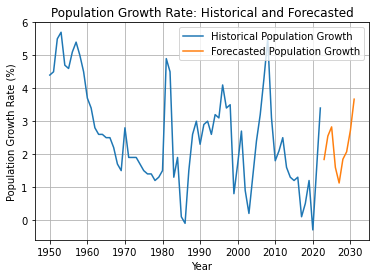

In [18]:
# Plot historical population growth data
plt.plot(pop_growth_interpolated.index, pop_growth_interpolated['Total Population Growth (Per Cent)'], label='Historical Population Growth')

# Plot forecasted population growth data
plt.plot(forecasted_population_growth.index, forecasted_population_growth['growth_rate'] * 100, label='Forecasted Population Growth')

# Format the plot
plt.xlabel('Year')
plt.ylabel('Population Growth Rate (%)')
plt.title('Population Growth Rate: Historical and Forecasted')
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Forecasted data

In [19]:
forecasted_monthly_consumption = pd.DataFrame({'consumption': forecast_series})
display(forecasted_monthly_consumption)
display(forecasted_population_growth)

,consumption
2022-01-01,442.308396
2022-02-01,416.124279
2022-03-01,409.122728
2022-04-01,457.982698
2022-05-01,484.573730
...,...
2031-08-01,484.450781
2031-09-01,471.230610
2031-10-01,465.449599
2031-11-01,467.759175


,growth_rate
2023-01-01,0.018381
2024-01-01,0.025484
2025-01-01,0.028276
2026-01-01,0.015967
2027-01-01,0.011243
2028-01-01,0.018449
2029-01-01,0.020724
2030-01-01,0.027206
2031-01-01,0.036689


In [20]:
#Source: SINGAPORE DEPARTMENT OF STATISTICS
initial_population = 5637022
#Retrieved from: https://www.singstat.gov.sg/find-data/search-by-theme/households/households/latest-data
avg_people_per_household = 3.09

# Calculate the projected population
forecasted_population_growth['population'] = initial_population * (1 + forecasted_population_growth['growth_rate']).cumprod()

# Calculate the projected number of households
forecasted_population_growth['households'] = forecasted_population_growth['population'] / avg_people_per_household

# Merge the forecasted_population_growth DataFrame with the forecasted_monthly_consumption DataFrame
merged_data = pd.merge(forecasted_monthly_consumption, forecasted_population_growth['households'], left_index=True, right_index=True)

# Adjust the average monthly household electricity consumption
merged_data['adjusted_consumption'] = merged_data['consumption'] * merged_data['households']

# The 'adjusted_consumption' column now contains the adjusted average monthly household electricity consumption

In [21]:
# Convert adjusted_consumption from kWh to MWh
merged_data['adjusted_consumption_MWh'] = merged_data['adjusted_consumption'] / 1000

display(merged_data)

,consumption,households,adjusted_consumption,adjusted_consumption_MWh
2023-01-01,423.376002,1.857811e+06,7.865524e+08,786552.392184
2024-01-01,419.240858,1.905155e+06,7.987187e+08,798718.749475
2025-01-01,417.854228,1.959025e+06,8.185870e+08,818586.992333
2026-01-01,420.054977,1.990304e+06,8.360371e+08,836037.124561
2027-01-01,420.434812,2.012680e+06,8.462009e+08,846200.880582
2028-01-01,420.409914,2.049812e+06,8.617615e+08,861761.467619
2029-01-01,420.130193,2.092292e+06,8.790352e+08,879035.231584
2030-01-01,420.070614,2.149216e+06,9.028226e+08,902822.590385
2031-01-01,420.057724,2.228069e+06,9.359175e+08,935917.526924


In [22]:
annual_energy_consumption = merged_data['adjusted_consumption_MWh']

# Rename the series for clarity
annual_energy_consumption.name = 'Total Annual Energy Consumption (MWh)'

# Display the annual energy consumption data
display(annual_energy_consumption)

2023-01-01    786552.392184
2024-01-01    798718.749475
2025-01-01    818586.992333
2026-01-01    836037.124561
2027-01-01    846200.880582
2028-01-01    861761.467619
2029-01-01    879035.231584
2030-01-01    902822.590385
2031-01-01    935917.526924
Name: Total Annual Energy Consumption (MWh), dtype: float64

## ARIMA for the Total Capacity

In [23]:
# Select the 'Total Capacity (MWh)' column as the time series data
total_capacity_ts = plant_availability_factors['Total Capacity (MWh)']

capacity_best_model = pm.auto_arima(total_capacity_ts,
                                    seasonal=True, m=12,
                                    d=1, D=1,
                                    max_p=3, max_q=3,
                                    max_P=3, max_Q=3,
                                    trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)

capacity_best_model.fit(total_capacity_ts)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6072.120, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6067.957, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6067.147, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6071.847, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=6060.345, Time=1.72 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=6056.910, Time=1.96 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=6065.903, Time=1.40 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=6059.500, Time=2.51 sec
 ARIMA(0,1,2)(0,1,3)[12]             : AIC=6058.170, Time=2.03 sec
 ARIMA(1,1,0)(0,1,3)[12]             : AIC=6056.669, Time=2.63 sec
 ARIMA(1,1,0)(0,1,2)[12]             : 

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 3, 12),
      suppress_warnings=True, with_intercept=False)

In [24]:
capacity_forecast, capacity_conf_int = capacity_best_model.predict(n_periods=108, return_conf_int=True)
capacity_forecast_index = pd.date_range(total_capacity_ts.index[-1], periods=109, closed='right', freq='MS')
capacity_forecast_series = pd.Series(capacity_forecast, index=capacity_forecast_index)
display(capacity_forecast_series)

2023-01-01    9.251110e+06
2023-02-01    9.256750e+06
2023-03-01    9.265230e+06
2023-04-01    9.293471e+06
2023-05-01    9.305818e+06
                  ...     
2031-08-01    1.021263e+07
2031-09-01    1.017646e+07
2031-10-01    1.019035e+07
2031-11-01    1.019630e+07
2031-12-01    1.027421e+07
Freq: MS, Length: 108, dtype: float64

## Forecasting the Total Capacity for the next 10 years

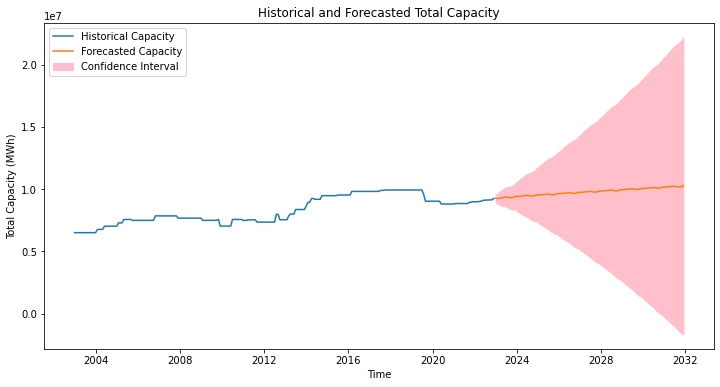

In [25]:
# Create a new DataFrame to hold the forecasted values
forecast_capacity_df = pd.DataFrame(capacity_forecast_series, columns=['Forecast Capacity'])

# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(total_capacity_ts, label='Historical Capacity')
plt.plot(forecast_capacity_df, label='Forecasted Capacity')
plt.fill_between(capacity_forecast_index, capacity_conf_int[:, 0], capacity_conf_int[:, 1], color='pink', label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Total Capacity (MWh)')
plt.title('Historical and Forecasted Total Capacity')
plt.legend(loc='upper left')
plt.show()

In [26]:
forecasted_total_capacity = pd.DataFrame({'Total Capacity (MWh)': capacity_forecast_series})
forecasted_total_capacity['Year'] = forecasted_total_capacity.index.year
forecasted_annual_capacity = forecasted_total_capacity.groupby('Year')['Total Capacity (MWh)'].mean()
forecasted_annual_capacity_list = forecasted_annual_capacity.tolist()

In [27]:
# Extract annual capacity factors and convert them to a list
plant_availability_factors['Year'] = pd.to_datetime(plant_availability_factors.index).year
annual_mean_capacity_factors = plant_availability_factors.groupby('Year')['Capacity Factor'].mean()
annual_mean_capacity_factors_list = annual_mean_capacity_factors.tolist()

## Linear Regression for Total Capacity

In [28]:
# Perform linear regression
X = np.array(proportions_df['Year']).reshape(-1, 1)
y = np.array(proportions_df['Proportion']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Forecast future proportions
forecast_years = np.array(range(2023, 2032)).reshape(-1, 1)
forecasted_proportions = reg.predict(forecast_years).flatten()

# Create a dictionary with year as key and forecasted proportion as value
forecasted_proportions_dict = {year: prop for year, prop in zip(range(2023, 2032), forecasted_proportions)}

print(forecasted_proportions_dict)

{2023: 0.1435515151515152, 2024: 0.14275757575757586, 2025: 0.14196363636363651, 2026: 0.14116969696969717, 2027: 0.14037575757575782, 2028: 0.13958181818181825, 2029: 0.1387878787878789, 2030: 0.13799393939393956, 2031: 0.1372000000000002}


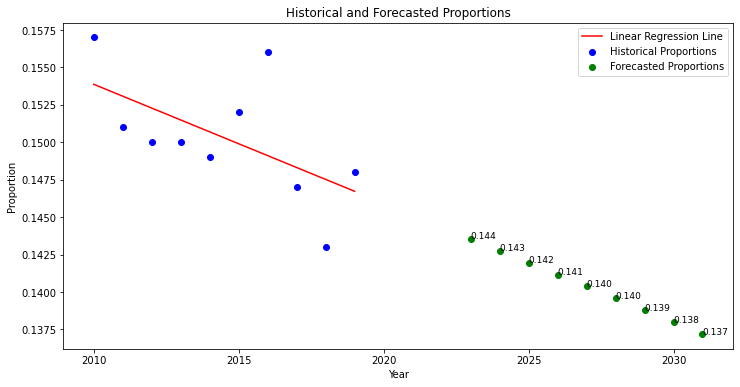

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(proportions_df['Year'], proportions_df['Proportion'], label='Historical Proportions', color='blue')
plt.plot(X, reg.predict(X), color='red', label='Linear Regression Line')
plt.scatter(forecast_years, forecasted_proportions, color='green', label='Forecasted Proportions')

for year, prop in forecasted_proportions_dict.items():
    plt.text(year, prop, f'{prop:.3f}', fontsize=9)

plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Historical and Forecasted Proportions')
plt.legend(loc='upper right')
plt.show()

## Monte Carlo Simulation for Capacity Factors

In [30]:
# Simulation parameters
num_years_to_predict = len(annual_energy_consumption)
num_trials = 1000

# Function for a single Monte Carlo trial
def monte_carlo_simulation(availability_factors, num_years, energy_data, forecasted_capacity_data, forecasted_proportions):
    energy_balance = pd.DataFrame(columns=['Year', 'Surplus/Deficit'])

    simulated_availability_factors = []
    for _ in range(len(energy_data)):
        simulated_factor = random.choice(availability_factors)
        simulated_availability_factors.append(simulated_factor)

    forecasted_proportions_years = list(forecasted_proportions.keys())
    
    for i, energy in enumerate(energy_data):
        year = energy_data.index[i].year
        proportion = forecasted_proportions[forecasted_proportions_years[i]]
        household_capacity = forecasted_capacity_data[i] * proportion
        produced_energy = household_capacity * simulated_availability_factors[i]
        surplus_deficit = produced_energy - energy
        energy_balance = energy_balance.append({'Year': year, 'Surplus/Deficit': surplus_deficit}, ignore_index=True)

    return energy_balance

In [31]:
# Run the Monte Carlo simulation num_trials times
trials = []
for i in range(num_trials):
    result = monte_carlo_simulation(annual_mean_capacity_factors_list, num_years_to_predict, annual_energy_consumption, forecasted_annual_capacity_list, forecasted_proportions_dict)
    trials.append(result)

# Analyze the results
trials_df = pd.concat(trials)
trials_df_grouped = trials_df.groupby('Year')
summary_stats = trials_df_grouped['Surplus/Deficit'].agg(['mean', 'median', 'std'])

print(summary_stats)

                 mean         median           std
Year                                              
2023.0  339993.531022  343713.821373  32619.178599
2024.0  340127.224755  349458.959322  32531.017404
2025.0  325720.249832  329674.889958  32655.383174
2026.0  315324.845224  318317.268621  32853.056616
2027.0  311702.946535  321190.489524  32463.568345
2028.0  302788.010896  311476.340754  33544.358246
2029.0  289426.815112  299907.395716  33259.208965
2030.0  270778.791204  281683.236503  32883.689635
2031.0  243295.107422  254009.880214  34021.235956


## Resulting Surplus/Deficit

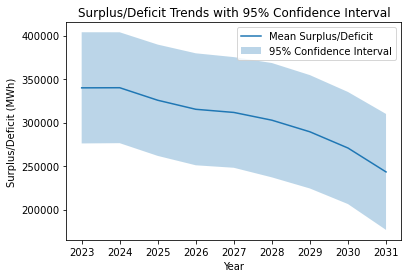

In [32]:
# Create visualizations
fig, ax = plt.subplots()

years = summary_stats.index
mean = summary_stats['mean']
median = summary_stats['median']
std = summary_stats['std']

lower_bound = mean - 1.96 * std
upper_bound = mean + 1.96 * std

ax.plot(years, mean, label='Mean Surplus/Deficit')
ax.fill_between(years, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

ax.set_xlabel('Year')
ax.set_ylabel('Surplus/Deficit (MWh)')
ax.set_title('Surplus/Deficit Trends with 95% Confidence Interval')
ax.legend()

plt.show()

In [33]:
# Load the dataset
historical_household = pd.read_csv('Historical Household.csv')
print(historical_household)

    Year Resident Households
0   2005           1,024,500
1   2006           1,054,100
2   2007           1,074,800
3   2008           1,093,100
4   2009           1,119,600
5   2010           1,145,900
6   2011           1,146,200
7   2012           1,152,000
8   2013           1,174,500
9   2014           1,200,000
10  2015           1,225,300
11  2016           1,263,600
12  2017           1,289,900
13  2018           1,325,300
14  2019           1,372,400
15  2020           1,372,600
16  2021           1,390,600
17  2022           1,399,600


In [34]:
# Extract the year from the 'Date' column
df_interpolated['Year'] = df_interpolated.index.year

# Group by year and find the average consumption
yearly_avg_consumption = df_interpolated.groupby('Year')['Consumption'].mean().reset_index()

print(yearly_avg_consumption)

    Year  Consumption
0   2005   471.066667
1   2006   468.958333
2   2007   468.650000
3   2008   457.750000
4   2009   476.600000
5   2010   485.091667
6   2011   466.700000
7   2012   467.433333
8   2013   469.000000
9   2014   465.875000
10  2015   468.108333
11  2016   475.325000
12  2017   444.166667
13  2018   421.800000
14  2019   428.958333
15  2020   444.183333
16  2021   458.641667


In [35]:
# Merge the two DataFrames on the 'Year' column
combined_df = pd.merge(yearly_avg_consumption, historical_household, on='Year')
# Convert the 'Resident Households' column to float (remove commas)
combined_df['Resident Households'] = combined_df['Resident Households'].str.replace(',', '').astype(float)
# Calculate the total energy consumption for each year
combined_df['Total Energy Consumption (in MWh)'] = combined_df['Consumption'] * combined_df['Resident Households'] / 1000
display(combined_df)

,Year,Consumption,Resident Households,Total Energy Consumption (in MWh)
0,2005,471.066667,1024500.0,482607.800000
1,2006,468.958333,1054100.0,494328.979167
2,2007,468.650000,1074800.0,503705.020000
3,2008,457.750000,1093100.0,500366.525000
4,2009,476.600000,1119600.0,533601.360000
5,2010,485.091667,1145900.0,555866.540833
6,2011,466.700000,1146200.0,534931.540000
7,2012,467.433333,1152000.0,538483.200000
8,2013,469.000000,1174500.0,550840.500000
9,2014,465.875000,1200000.0,559050.000000


In [36]:
# Convert the index to a datetime object
plant_availability_factors.index = pd.to_datetime(plant_availability_factors.index)

# Calculate the yearly mean of plant_availability_factors
plant_availability_factors_yearly = plant_availability_factors.resample('Y').mean()
plant_availability_factors_yearly.reset_index(inplace=True)
plant_availability_factors_yearly['Year'] = plant_availability_factors_yearly['Month'].dt.year

# Merge combined_df and plant_availability_factors_yearly DataFrames
merged_df = pd.merge(combined_df, plant_availability_factors_yearly, on='Year', how='inner')


# Find missing years
all_years = set(range(merged_df['Year'].min(), merged_df['Year'].max() + 1))
missing_years = all_years - set(proportions_df['Year'])

# Predict proportions for missing years using the linear regression model
missing_years_array = np.array(sorted(list(missing_years))).reshape(-1, 1)
missing_proportions = reg.predict(missing_years_array).flatten()

# Add missing proportions to the proportions_df DataFrame
missing_proportions_df = pd.DataFrame({'Year': missing_years_array.flatten(), 'Proportion': missing_proportions})
proportions_df = proportions_df.append(missing_proportions_df, ignore_index=True).sort_values(by='Year').reset_index(drop=True)

# Merge combined_df, plant_availability_factors_yearly, and proportions_df DataFrames
merged_df = pd.merge(merged_df, proportions_df, on='Year')

# Calculate historical surplus/deficit
merged_df['Surplus/Deficit (MWh)'] = merged_df['Total Capacity (MWh)']* merged_df['Proportion'] - (merged_df['Total Energy Consumption (in MWh)'] )

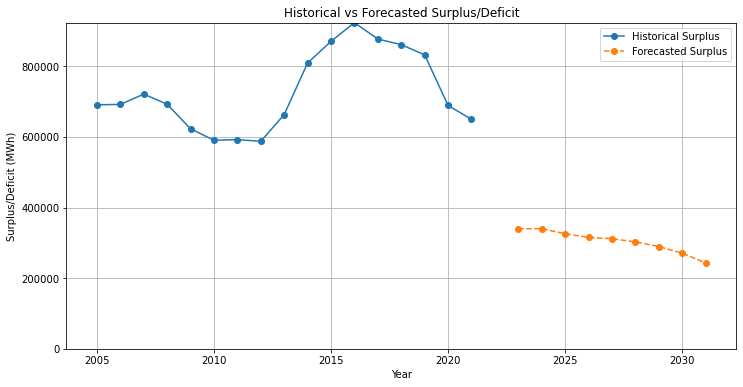

In [37]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Surplus/Deficit (MWh)'], label='Historical Surplus', marker='o')
plt.plot(summary_stats.index, summary_stats['mean'], label='Forecasted Surplus', marker='o', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Surplus/Deficit (MWh)')
plt.title('Historical vs Forecasted Surplus/Deficit')
plt.legend()
plt.grid()

# Set the y-axis limits
plt.ylim(0, max(merged_df['Surplus/Deficit (MWh)'].max(), trials_df['Surplus/Deficit'].max()))

plt.show()